In [1]:
    #Required libraries
    import pandas as pd
    import numpy as np
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import train_test_split, cross_val_score
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
    from sklearn.preprocessing import StandardScaler, LabelEncoder
    import matplotlib.pyplot as plt
    import seaborn as sns
    from skopt import BayesSearchCV
    from skopt.space import Integer, Real

In [4]:
    # Load datasets into pandas DataFrames for Training dataset
    dt_outpatient = pd.read_csv('Train_Outpatientdata.csv',nrows=30000)
    dt_inpatient = pd.read_csv('Train_Inpatientdata.csv')
    dt_beneficiary = pd.read_csv('Train_Beneficiarydata.csv',nrows=10000)
    dt_fraud = pd.read_csv('Train.csv')
    # Display the first few rows to inspect the data
    print("Outpatient Data:")
    print(f"Outpatient Data Shape: {dt_outpatient.shape}")
    print(dt_outpatient.head())
    print("\nInpatient Data:")
    print(dt_inpatient.head())
    print(f"Beneficiary Data Shape: {dt_beneficiary.shape}")
    print("\nBeneficiary Data:")
    print(dt_beneficiary.head())
    print("\nFraud Data:")
    print(dt_fraud.head())

Outpatient Data:
Outpatient Data Shape: (30000, 27)
      BeneID    ClaimID ClaimStartDt  ClaimEndDt  Provider  \
0  BENE11002  CLM624349   2009-10-11  2009-10-11  PRV56011   
1  BENE11003  CLM189947   2009-02-12  2009-02-12  PRV57610   
2  BENE11003  CLM438021   2009-06-27  2009-06-27  PRV57595   
3  BENE11004  CLM121801   2009-01-06  2009-01-06  PRV56011   
4  BENE11004  CLM150998   2009-01-22  2009-01-22  PRV56011   

   InscClaimAmtReimbursed AttendingPhysician OperatingPhysician  \
0                      30          PHY326117                NaN   
1                      80          PHY362868                NaN   
2                      10          PHY328821                NaN   
3                      40          PHY334319                NaN   
4                     200          PHY403831                NaN   

  OtherPhysician ClmDiagnosisCode_1  ... ClmDiagnosisCode_9  \
0            NaN              78943  ...                NaN   
1            NaN               6115  ...      

In [5]:
    #Merging the dataset based on beneficiary ID
    #Merging outpatient data with beneficiary data
    merged_outpatient = pd.merge(dt_outpatient,dt_beneficiary, how='inner',on='BeneID')
     #Merging inpatient data with beneficiary data
    merged_inpatient = pd.merge(dt_inpatient,dt_beneficiary, how='inner',on='BeneID')
    #Combining inpatient and outpatient datasets
    merged_data = pd.concat([merged_outpatient,merged_inpatient], ignore_index=True)
    #Merging the combined patient data with 'train_fraud' dataset using 'Provider'
    merged_data = pd.merge(merged_data,dt_fraud, how='inner', on ='Provider')
    for col in merged_data.select_dtypes(include=['object']).columns:
        merged_data[col]=merged_data[col].astype('category')
    #Checking the shape and columns of the final merged data
    print("\nMerged Data Shape:",merged_data.shape)
    print("Merged Data columns:",merged_data.columns)
    print(merged_data.head())


Merged Data Shape: (32958, 55)
Merged Data columns: Index(['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
       'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',
       'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8',
       'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'ClmProcedureCode_1',
       'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4',
       'ClmProcedureCode_5', 'ClmProcedureCode_6', 'DeductibleAmtPaid',
       'ClmAdmitDiagnosisCode', 'DOB', 'DOD', 'Gender', 'Race',
       'RenalDiseaseIndicator', 'State', 'County', 'NoOfMonths_PartACov',
       'NoOfMonths_PartBCov', 'ChronicCond_Alzheimer',
       'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
       'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',
       'ChronicCond_Depression', 'ChronicCond_Diab

In [6]:
    #Handling missing values
    merged_data_cleaned=merged_data.dropna(axis=1)
    print("\nMerged Data Shape after removing NaN values:",merged_data_cleaned.shape)
    print("Merged Data columns after removing NaN values:",merged_data_cleaned.columns)
    print(merged_data_cleaned.head())


Merged Data Shape after removing NaN values: (32958, 30)
Merged Data columns after removing NaN values: Index(['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'DOB', 'Gender', 'Race',
       'RenalDiseaseIndicator', 'State', 'County', 'NoOfMonths_PartACov',
       'NoOfMonths_PartBCov', 'ChronicCond_Alzheimer',
       'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
       'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',
       'ChronicCond_Depression', 'ChronicCond_Diabetes',
       'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis',
       'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke',
       'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt',
       'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'PotentialFraud'],
      dtype='object')
      BeneID    ClaimID ClaimStartDt  ClaimEndDt  Provider  \
0  BENE11002  CLM624349   2009-10-11  2009-10-11  PRV56011   
1  BENE11004  CLM121801   2009-01-06  2009-01

In [7]:
    #Convert 'PotentialFraud' to binary
    merged_data_cleaned.loc[:,'PotentialFraud'] = merged_data_cleaned['PotentialFraud'].map({'Yes':1, 'No':0})
    X_dt=merged_data_cleaned.drop(columns=['PotentialFraud']) #Features
    y=merged_data_cleaned['PotentialFraud'] #Target
    #Encoding categorical variables and scaling numberical features
    X_dt_encoded = pd.get_dummies(X_dt, drop_first=True, sparse=True)
    #Display the processed dataset
    print ("\nProcessed Data Shape:",X_dt_encoded.shape)
    print("Processed Data Columns:",X_dt_encoded.columns)
    print ("\nProcessed Data Shape:",y.shape)


Processed Data Shape: (32958, 46663)
Processed Data Columns: Index(['InscClaimAmtReimbursed', 'Gender', 'Race', 'State', 'County',
       'NoOfMonths_PartACov', 'NoOfMonths_PartBCov', 'ChronicCond_Alzheimer',
       'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
       ...
       'DOB_1982-10-01', 'DOB_1982-11-01', 'DOB_1983-01-01', 'DOB_1983-04-01',
       'DOB_1983-05-01', 'DOB_1983-06-01', 'DOB_1983-07-01', 'DOB_1983-09-01',
       'DOB_1983-12-01', 'RenalDiseaseIndicator_Y'],
      dtype='object', length=46663)

Processed Data Shape: (32958,)


In [9]:
    #Splitting data into training+validation and test sets
    X_train_val, X_test, y_train_val, y_test = train_test_split(X_dt_encoded,y,test_size=0.2, random_state=42)
    # Then splitting the training_validation set into training and validation sets
    X_train,X_val,y_train,y_val = train_test_split(X_train_val,y_train_val,test_size=0.25,random_state=42)
    # This results in 60% train, 20% validation, 20% test
    #Initialize the RandomForestClassifier
    baseline_model = RandomForestClassifier(random_state=42)
    #Fit the model on the training data
    baseline_model.fit(X_train, y_train)
    #Make predictions on the validation data
    y_val_pred = baseline_model.predict(X_val)
    #Evaluate the model
    print("Baseline Model performance on Validation set:")
    print(f"Accuracy: {accuracy_score(y_val,y_val_pred):.4f}")
    print(f"Precision: {precision_score(y_val,y_val_pred):4f}")
    print(f"F1-Score: {f1_score(y_val,y_val_pred):.4f}")
    print(f"ROC AUC: {roc_auc_score(y_val,y_val_pred):.4f}")

C:\Users\Pragya\anaconda3\Lib\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Pragya\anaconda3\Lib\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


Baseline Model performance on Validation set:
Accuracy: 0.9375
Precision: 0.980925
F1-Score: 0.9090
ROC AUC: 0.9186


In [15]:
    #Defining parameter space for Bayesian Optimization
    param_space = {
        'n_estimators': (10,100),
        'max_depth': (1,50),
        'min_samples_split': (2,20),
        'min_samples_leaf': (1,20),
        'max_features': ['auto','sqrt','log2'],
}
    # Initialize the RandomForestClassifier
    rf = RandomForestClassifier(random_state=42)
    #Initialize Bayesian search
    bayes_search = BayesSearchCV(
        estimator = rf,
        search_spaces=param_space,
        n_iter=20, # number of iterations for tuning
        cv=3, # 3-fold cross validation
        random_state=42,
        n_jobs=-1
    )
    # Fit Bayesian optimization
    bayes_search.fit(X_train,y_train)
    # Best parameters found
    print("Best parameters:", bayes_search.best_params_)
    # Evaluation on the validation set with the best model
    y_val_pred_best=bayes_search.best_estimator_.predict(X_val)
    # Printing the performaance of the tuned model
    print("Tuned Model performance on validation set:")
    print(f"Accuracy: {accuracy_score(y_val,y_val_pred_best):.4f}")
    print(f"Precision: {precision_score(y_val,y_val_pred_best):4f}")
    print(f"Recall: {recall_score(y_val,y_val_pred_best):.4f}")
    print(f"F1-Score: {f1_score(y_val,y_val_pred_best):.4f}")
    print(f"ROC AUC: {roc_auc_score(y_val,y_val_pred_best):.4f}")

C:\Users\Pragya\anaconda3\Lib\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Pragya\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Best parameters: OrderedDict([('max_depth', 50), ('max_features', 'auto'), ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estimators', 10)])


C:\Users\Pragya\anaconda3\Lib\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


Tuned Model performance on validation set:
Accuracy: 0.7121
Precision: 0.976661
Recall: 0.2240
F1-Score: 0.3644
ROC AUC: 0.6104


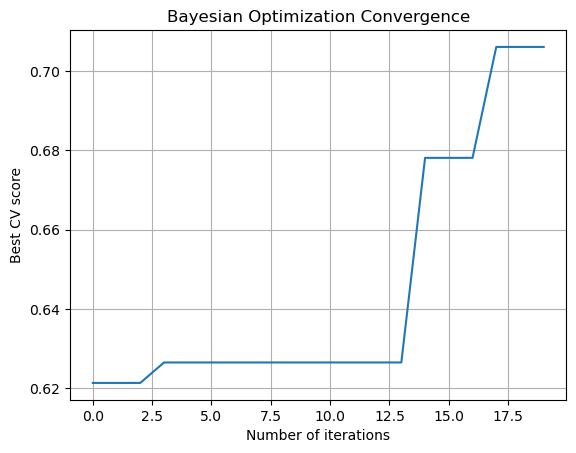

In [20]:
    import matplotlib.pyplot as plt
    # Extract the best scores during optimization
    best_scores = [max(bayes_search.cv_results_['mean_test_score'][:i+1]) for i in
                   range(len(bayes_search.cv_results_['mean_test_score']))]
    #Plot the convergence of the Bayesian Optimization process
    plt.plot(best_scores)
    plt.title("Bayesian Optimization Convergence")
    plt.xlabel("Number of iterations")
    plt.ylabel("Best CV score")
    plt.grid(True)           
    plt.show()

In [21]:
    # Running the optimized model on test set
    #Getting the best model after Bayesian Optimization
    best_model = bayes_search.best_estimator_
    best_model.fit(X_train_val, y_train_val)
    # Fittting on the full training + validation set
    # Making predictions on the test set
    y_test_pred = best_model.predict(X_test)
    # Evaluate the model on test set
    print("Test set Performance:")
    print(f"Accuracy: {accuracy_score(y_test,y_test_pred):.4f}")
    print(f"Precision: {precision_score(y_test,y_test_pred):4f}")
    print(f"Recall: {recall_score(y_test,y_test_pred):.4f}")
    print(f"F1-Score: {f1_score(y_test,y_test_pred):.4f}")
    print(f"ROC AUC: {roc_auc_score(y_test,y_test_pred):.4f}")

C:\Users\Pragya\anaconda3\Lib\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Pragya\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Pragya\anaconda3\Lib\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


Test set Performance:
Accuracy: 0.6940
Precision: 1.000000
Recall: 0.1938
F1-Score: 0.3247
ROC AUC: 0.5969
